# von2Dank

von2Dank is a simple, 2-dimensional, cylindrical geometry, hydrodynamics code that I've been using to make some simple models of astrophysical disks.

The main job of von2Dank is to solve the continuity and momentum equations of fluid dynamics, as well as the Poisson equation:

$\let\vec\mathbf$
$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \vec{u}) = 0 $$
$$ \frac{\partial \vec{u}}{\partial t} + \vec{u} \cdot \nabla \vec{u} + \frac{\nabla p}{\rho} = -\nabla\Phi $$
$$ \Phi = -\int \frac{G \rho(\vec{x^{\prime}}) d^3\vec{x^{\prime}}}{|\vec{x^{\prime}} - \vec{x}|} $$

von2Dank solves the fluid equations using finite difference approximations, and the Poisson equation using a FFT 2D potential solver.

von2Dank is written entirely in python, and is an adaptation of a similar fortran code (Laughlin et al., 1997ApJ...477..410L). "Why python? That must be so slow" you might reasonably ask. Well, indeed it is not as fast as an equivalent compiled code, but it is just about as fast as it could possibly be in python. In solving the difference equations, no "for" loops are used to calculate the values in each cell. Instead, matrix equations are used to update the entire grid at once.

The program also includes artificial viscosity, kinematic viscosity, and a runga-kutta integrator for a central mass and one perturbing body (e.g. a planet). It respects the courant condition, and reflective boundary conditions at the disk edges (though the viscosity should damp things out in the inner and outer soak zones).

I'm working on adding more functionality and ironing out bugs, because as of now the code is not very flexible since I geared it towrads the specific problems I was studying.

#  quickstart

In this quickstart notebook, I'll show you the basic usage.

First, the following dependencies are required:
* numpy
* pandas

Both can be installed using `pip`.

Once you have those packages installed, the first thing you must do is clone this repository. Lets see the contents:

In [1]:
ls

defs.py   output/	 parameters.pyc    von2Dank.py
defs.pyc  parameters.py  quickstart.ipynb


As you can see, there are just a few python scripts and python notebooks, and an output directory (initially empty).

The only file you should ever need to edit is the `parameters.py` file.

Let's take a look at that file:

In [2]:
cat parameters.py

###############################
# output and timing options
###############################
run_name = 'quickstart' # will appear at the end of the output filenames
verbose = 0 # True to print the timestep 
nprint = 1 # print out the time to the terminal after every nprint timesteps if verbose = 1
outint = 0.5 # time interval for output (in units of the system time)
trun = 10. # expected elapsed system time at finish
nsteps = int(1e9) # maximum number of timesteps allowed

###############################
# resolution
###############################
nr = 64 # number of radial grid points
nphi = nr*2 # number of azimuthal grid points

###############################
# star and planet
###############################
mstar = 1.0 # mass of the central star in solar masses
mplanet = 1.e-3 # mass of planet, in units of the star mass
ecc = 0. # eccentricity of orbit
dperi = 1.5 # periastron distance in AU
lperi = 0. # longitude of periastron in radians
meananom = 0. # initial mean anomaly in r

As you can see, it's a python script in which there are a bunch of parameters with assigned values. Most of the parameters are annotated, but may not be obvious what they do. I will describe them (and their acceptable ranges) in detail in a separate document (coming soon). For now, let's just do a test run with this configuration: a roughly jupiter-mass planet in a circular orbit around a sun-mass star at a distance of 1.5 AU. The disk has a mass of 5 percent the mass of the star, spans about 3 AU, has a gaussian initial surface density profile with a peak at 1 AU and a spread of 0.5 AU, and has a minimum toomre $Q$ value of about 1.5, so we should see some effects of gravitational instability if we run it for long enough. A resolution of 64x128 is fairly low, but let's just keep it for this test run.

The code can be run at the command line by simply doing `python von2Dank.py` (or `%run von2Dank.py` in a python notebook).

In [3]:
%%time
%run von2Dank.py

writing at istep = 1, time = 0.0, dt = 1e-05
writing at istep = 47, time = 0.502332353044, dt = 0.00583161338643
writing at istep = 134, time = 1.00092977588, dt = 0.00564045534753
writing at istep = 224, time = 1.5017170245, dt = 0.0055196287432
writing at istep = 315, time = 2.00313489863, dt = 0.00548930203337
writing at istep = 406, time = 2.50535237181, dt = 0.00542551103932
writing at istep = 498, time = 3.00377064618, dt = 0.00536865634845
writing at istep = 590, time = 3.50400201679, dt = 0.00547361456428
writing at istep = 681, time = 4.00113670591, dt = 0.00545394739221
writing at istep = 772, time = 4.50144715479, dt = 0.00557903229998
writing at istep = 862, time = 5.00312070179, dt = 0.00559071388225
writing at istep = 950, time = 5.50229625397, dt = 0.00574696241737
writing at istep = 1037, time = 6.00512690562, dt = 0.00581961266675
writing at istep = 1123, time = 6.50237828045, dt = 0.00569458113743
writing at istep = 1211, time = 7.00473973249, dt = 0.00568310122866
wr

The code has now printed several output files which can be found in `output/`.

The main output file is the `snapshots_<run_name>.h5`, which is an hdf5 file that contains `trun`/`outint` keys, each of which contains the entire density array for that snapshot.

In a separate notebook I will show examples of Fourier decomposition and mode analysis, but for now lets just make a movie of the disk and body dyanmics using `matplotlib`.

# Movie of output

First, let's import the relevant libraries, write a helper function to grab the data, and then grab the data, and set the limits for the colorscale.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import pandas as pd

In [21]:
def grabdata():
    global suff
    suff = 'quickstart'
    rcoord = np.genfromtxt('output/coordinates_%s.out' %suff,skip_header=1,skip_footer=1)
    phicoord = np.genfromtxt('output/coordinates_%s.out' %suff,skip_header=2,skip_footer=0)
    coords = np.array([rcoord,phicoord])
    bods = np.loadtxt('output/bodies_%s.out' %suff)
    toomreQ = np.genfromtxt('output/toomreQ_%s.out' %suff,skip_header=1)
    times = np.loadtxt('output/timesteps_%s.out' %suff)
    store = pd.HDFStore('output/snapshots_%s.h5' %suff)
    return coords,bods,toomreQ,times,store

# grab data from output files
coords,bods,toomreQ,times,store = grabdata()
# unpack coords
r,phi = coords
# list of files output files in chronological order
k = store.keys()
f = np.argsort(np.array([int(x.split('_')[-1]) for x in k]))

In [22]:
# grab values from the first nonzero timestep to set the colorscale limits for uniform scaling
den = store[store.keys()[1]]
d = np.mean(den.T).values
sigmin, sigmax = np.min(d), np.max(d)
ddd = (den.T - d).T
vmin = -2.*np.min(np.min(ddd))
vmax = 2.*np.max(np.max(ddd))
# equilibrium density
den = store[store.keys()[0]]
d = den.T
d = np.mean(d)
ddd = np.array((den.T - d).T)
# bodies initial configuration
x1,y1,x2,y2,vx1,vy1,vx2,vy2 = bods[0]
r1 = np.sqrt(x1**2 + y1**2)
phi1 = np.arctan2(y1,x1)
r2 = np.sqrt(x2**2 + y2**2)
phi2 = np.arctan2(y2,x2)

In the following cells, I'm going to set up the figure and write a helper function for making an animated movie in this notebook. In order to make a movie from the command line, you can just save each output frame as an image file and then use `ffmpeg`, or make a `gif` from within python.

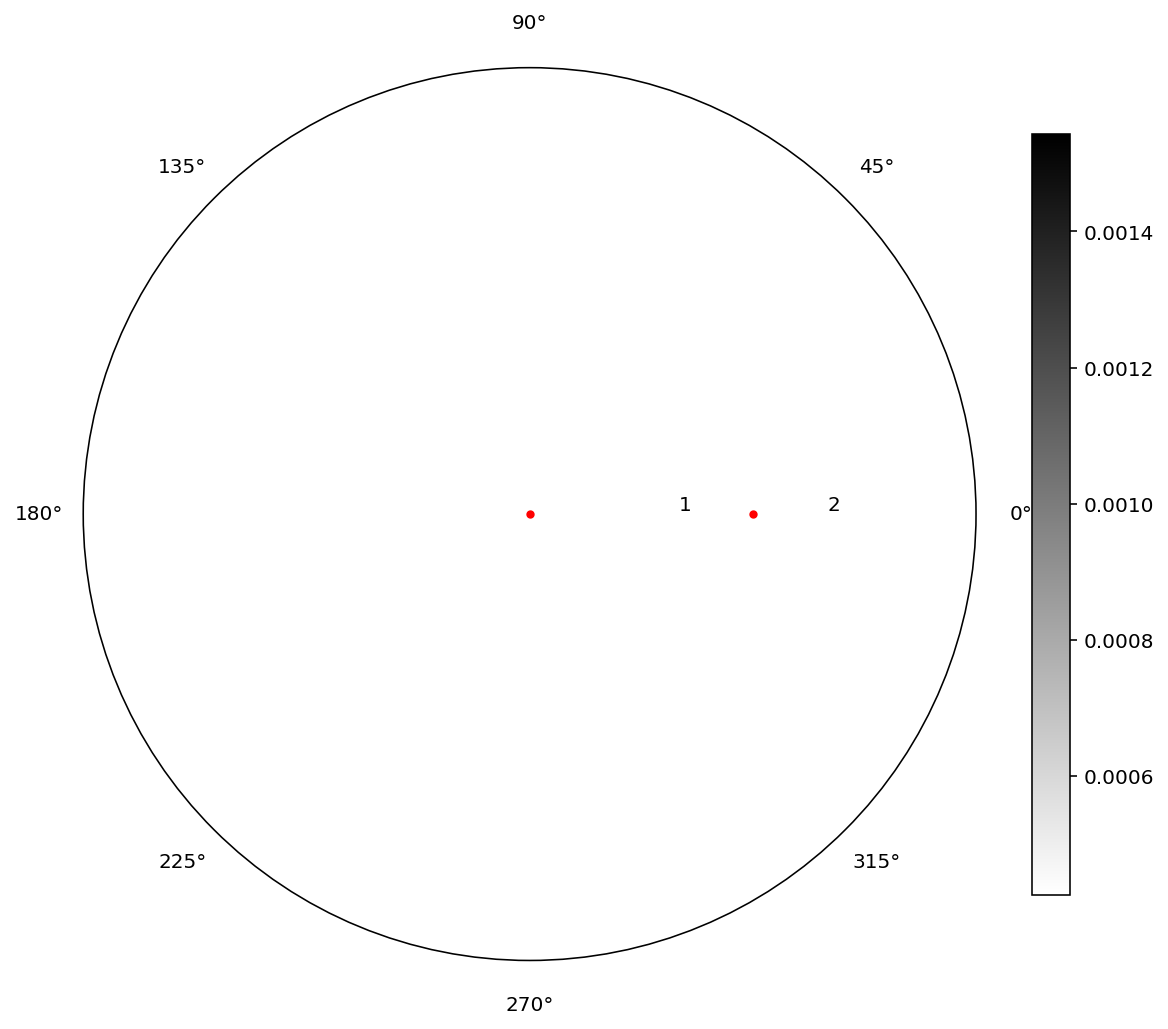

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='polar')
ax.set_rlim(0.,3.)
ax.set_rticks([1.,2.])
ax.set_rlabel_position(0.)
cax = ax.pcolormesh(phi,r,ddd,cmap='binary',vmin=vmin,vmax=vmax)
fig.colorbar(cax,shrink=0.7)
scat = ax.scatter([phi1,phi2],[r1,r2],c='r',s=10)

In [27]:
# animation function. This is called sequentially
def animate(i):
    den = store[store.keys()[f[i]]]
    d = den.T
    d = np.mean(d)
    ddd = (den.T - d).T
    ddd = np.array(ddd)
    #ddd = ddd[:-1,:-1] # comment out after this change is made in main program
    cax.set_array(ddd.flatten())
    # bodies
    x1,y1,x2,y2,vx1,vy1,vx2,vy2 = bods[i]
    r1 = np.sqrt(x1**2 + y1**2)
    phi1 = np.arctan2(y1,x1)
    r2 = np.sqrt(x2**2 + y2**2)
    phi2 = np.arctan2(y2,x2)
    scat.set_offsets(np.c_[[phi1,phi2],[r1,r2]])
    
anim = animation.FuncAnimation(fig, animate, interval=150, frames=len(k))
HTML(anim.to_html5_video())